### helper routines and constants

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6

#utility function to plot grids
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', title=None):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:    
        plt.title(title)
#plot_mesh_in_latlon(lams,phis,stride=16)
def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', title=None):
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, title=title)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

def metrics_error(dx_,dy_,area_,Ni,lat1,lat2=90,Re=_default_Re):
    exact_area = 2*np.pi*(Re**2)*np.abs(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = np.abs(lat2-lat1)*PI_180*Re  
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re

    grid_lat_arc_length = np.sum(dy_[:,Ni//4]) 
    grid_lon_arc_length = np.sum(dx_[0,:])
    if(lat1>lat2):
        grid_lon_arc_length = np.sum(dx_[-1,:])
        
    area_error = 100*(np.sum(area_)-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
#    print(exact_area)
#    print(np.sum(area_))
    return lat_arc_error,lon_arc_error,area_error
    

### grid parameters

In [2]:
# Specify the grid properties
# All
# Specify the desired resolution
degree_resolution_inverse = 4 #quarter degree grid
refine=2    # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = lenlon*refine*degree_resolution_inverse

#Mercator grid
lat0_Merc=-65.0  # This is a nominal starting latitude for Mercator grid
lenlat_Merc=125  # nominal latitude range of Mercator grid
# Specify approximate latitude range
#phi_s, phi_n = lat0_M,lat0_M+lenlat_M
# To reproduce MIDAS we need to change these to the values produced by MIDAS 
phi_s_Merc, phi_n_Merc = -66.85954724706843, 64.0589597296948

#Southern grid
Nj_SO=110*refine
lat0_SO=-78.0
lenlat_SO = phi_s_Merc-lat0_SO 

#Southern cap
Nj_scap=80*refine
lon_dp=100.0   # longitude of the displaced pole 
r_dp=0.20
doughnut=0.12

#Northern bipolar cap
Nj_ncap=119*refine
lon_bp=lon0 # longitude of the displaced pole(s)
lat0_bp=phi_n_Merc #61.247692871618455 #mercator.y.max()
lenlat_bp=90.0-lat0_bp



### Implementation of the algorithm

In [ ]:
def displaced_pole_cap_projection(lon_grid,lat_grid,lam_pole,z_0,r_joint):
    r = np.tan((90+lat_grid) *PI_180)/r_joint
    #Find the theta that has matching resolution at the unit circle with longitude at the joint
    #This is a conformal transformation the unit circle (inverse to the one below)
    e2itheta = np.exp(1j*lon_grid*PI_180) 
    e2ithetaprime = (e2itheta + z_0)/(1. + np.conj(z_0)*e2itheta)
    #Conformal map to displace pole from r=0 to r=r_dispole
    z=r*e2ithetaprime
    w=(z-z_0)/(1-np.conj(z_0)*z)
    #Inverse projection from tangent plane back to sphere
    lamcDP = np.angle(w, deg=True)
    #lamcDP = np.arctan2(np.imag(w), np.real(w))/PI_180
    #np.angle returns a value in the interval (-180,180)
    #However the input grid longitude is in (-lon0,-lon0+360), e.g., (-300,60)
    #We should shift the angle to be in that interval
    lamcDP = np.where(lamcDP>lon_grid[0,-1],lamcDP-360,lamcDP)
    #Niki: The second condition above is ad hoc. Work on a more elaborate condition to get rid of the  discontinuity at lon_grid>60
    #Another adhoc fix for single point correction
    lamcDP[-1,0] = lamcDP[-1,0]-360
    #
    rw=np.absolute(w)
    phicDP = -90+np.arctan(rw*r_joint)/PI_180
    return lamcDP,phicDP

    
def displaced_pole_cap_ij_array(i,j,Ni,Nj_scap,lon0,lam_pole,r_pole,lat_joint,excluded_fraction=None):
    long = lon0  + i * 360./float(Ni)
    a=-90.
    b=lat_joint #=-78.
    latg = a         + j * 0.5*(b-a)/float(Nj_scap//8-1)
    latg2 = 0.5*(b+a) + (j-Nj_scap//8)  *  0.5*(b-a)/float(7*Nj_scap//8)
    latg = np.where(j<Nj_scap//8,latg,latg2)
    #return long,latg
    lamg = np.tile(long,(latg.shape[0],1)) 
    phig = np.tile(latg.reshape((latg.shape[0],1)),(1,long.shape[0]))
    #Projection from center of globe to plane tangent at south pole
    r_joint = np.tan((90+lat_joint)*PI_180) 
    z_0= r_pole * np.exp(1j*lam_pole*PI_180) 
    lams,phis = displaced_pole_cap_projection(lamg,phig,lam_pole,z_0,r_joint)

    if excluded_fraction is not None:
        ny,nx = lamg.shape 
        jmin=np.ceil(excluded_fraction*ny)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return lams[jmint:,:], phis[jmint:,:]
    else:
        return lams,phis

def displaced_pole_cap_ij_s_i(i,j,eps=1.e-5):
    """Returns approximations to ds/di at locations [j,i]"""
    ip1,im1 = i+eps, i-eps
    ip2,im2 = i+2*eps, i-2*eps
    

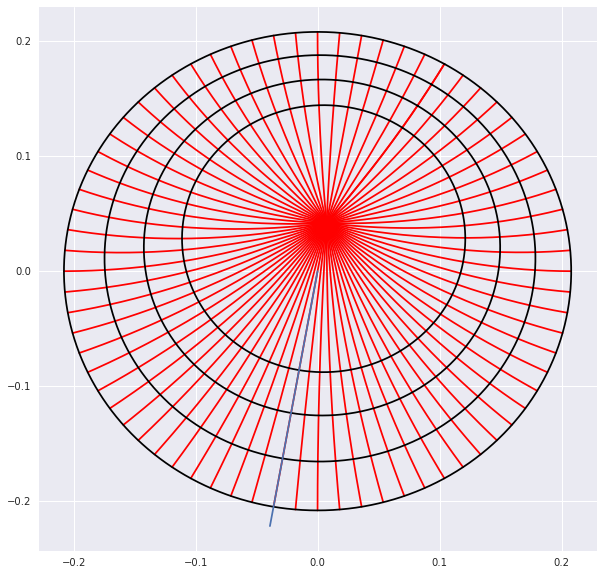

In [8]:
i_s=np.arange(Ni+1)
j_s=np.arange(Nj_scap+1)
x_s,y_s= displaced_pole_cap_ij_array(i_s,j_s,Ni,Nj_scap,lon0,lam_pole=-lon_dp,r_pole=0.2,lat_joint=lat0_SO,excluded_fraction=None)

#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(x_s,y_s, stride=40)

#plot the location of the displaced pole
lam__dp=np.array([-lon_dp])
phi__dp=np.array([lat0_SO+1,-90])
x__dp = np.cos(phi__dp*PI_180) * np.cos(lam__dp*PI_180)
y__dp = np.cos(phi__dp*PI_180) * np.sin(lam__dp*PI_180)
plt.plot(x__dp,y__dp)
